# Рекомендация партнеров с сопоставимыми или дополняющими профилями деятельности компании

In [1]:
!pip install --upgrade torch
!pip install dgl==0.9.1
# !pip install dgl
!pip install dill
import os
os.environ['DGLBACKEND'] = 'pytorch'
import dgl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 84.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 69.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 12.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━

In [2]:
!pip install rake_nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 33.0 MB/s eta 0:00:0000:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.


In [4]:
import sqlite3
import pandas as pd
import numpy as np
import networkx as nx
import community as community_louvain
import re

import dgl.function as fn

import random

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_auc_score, roc_curve


import spacy
from rake_nltk import Rake

import umap

from transformers import BertTokenizer, BertModel

import dgl
from dgl.nn.pytorch import HeteroGraphConv, SAGEConv, GraphConv

import torch
#from torch_geometric.data import Data
#from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
import torch.nn as nn

from collections import defaultdict

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

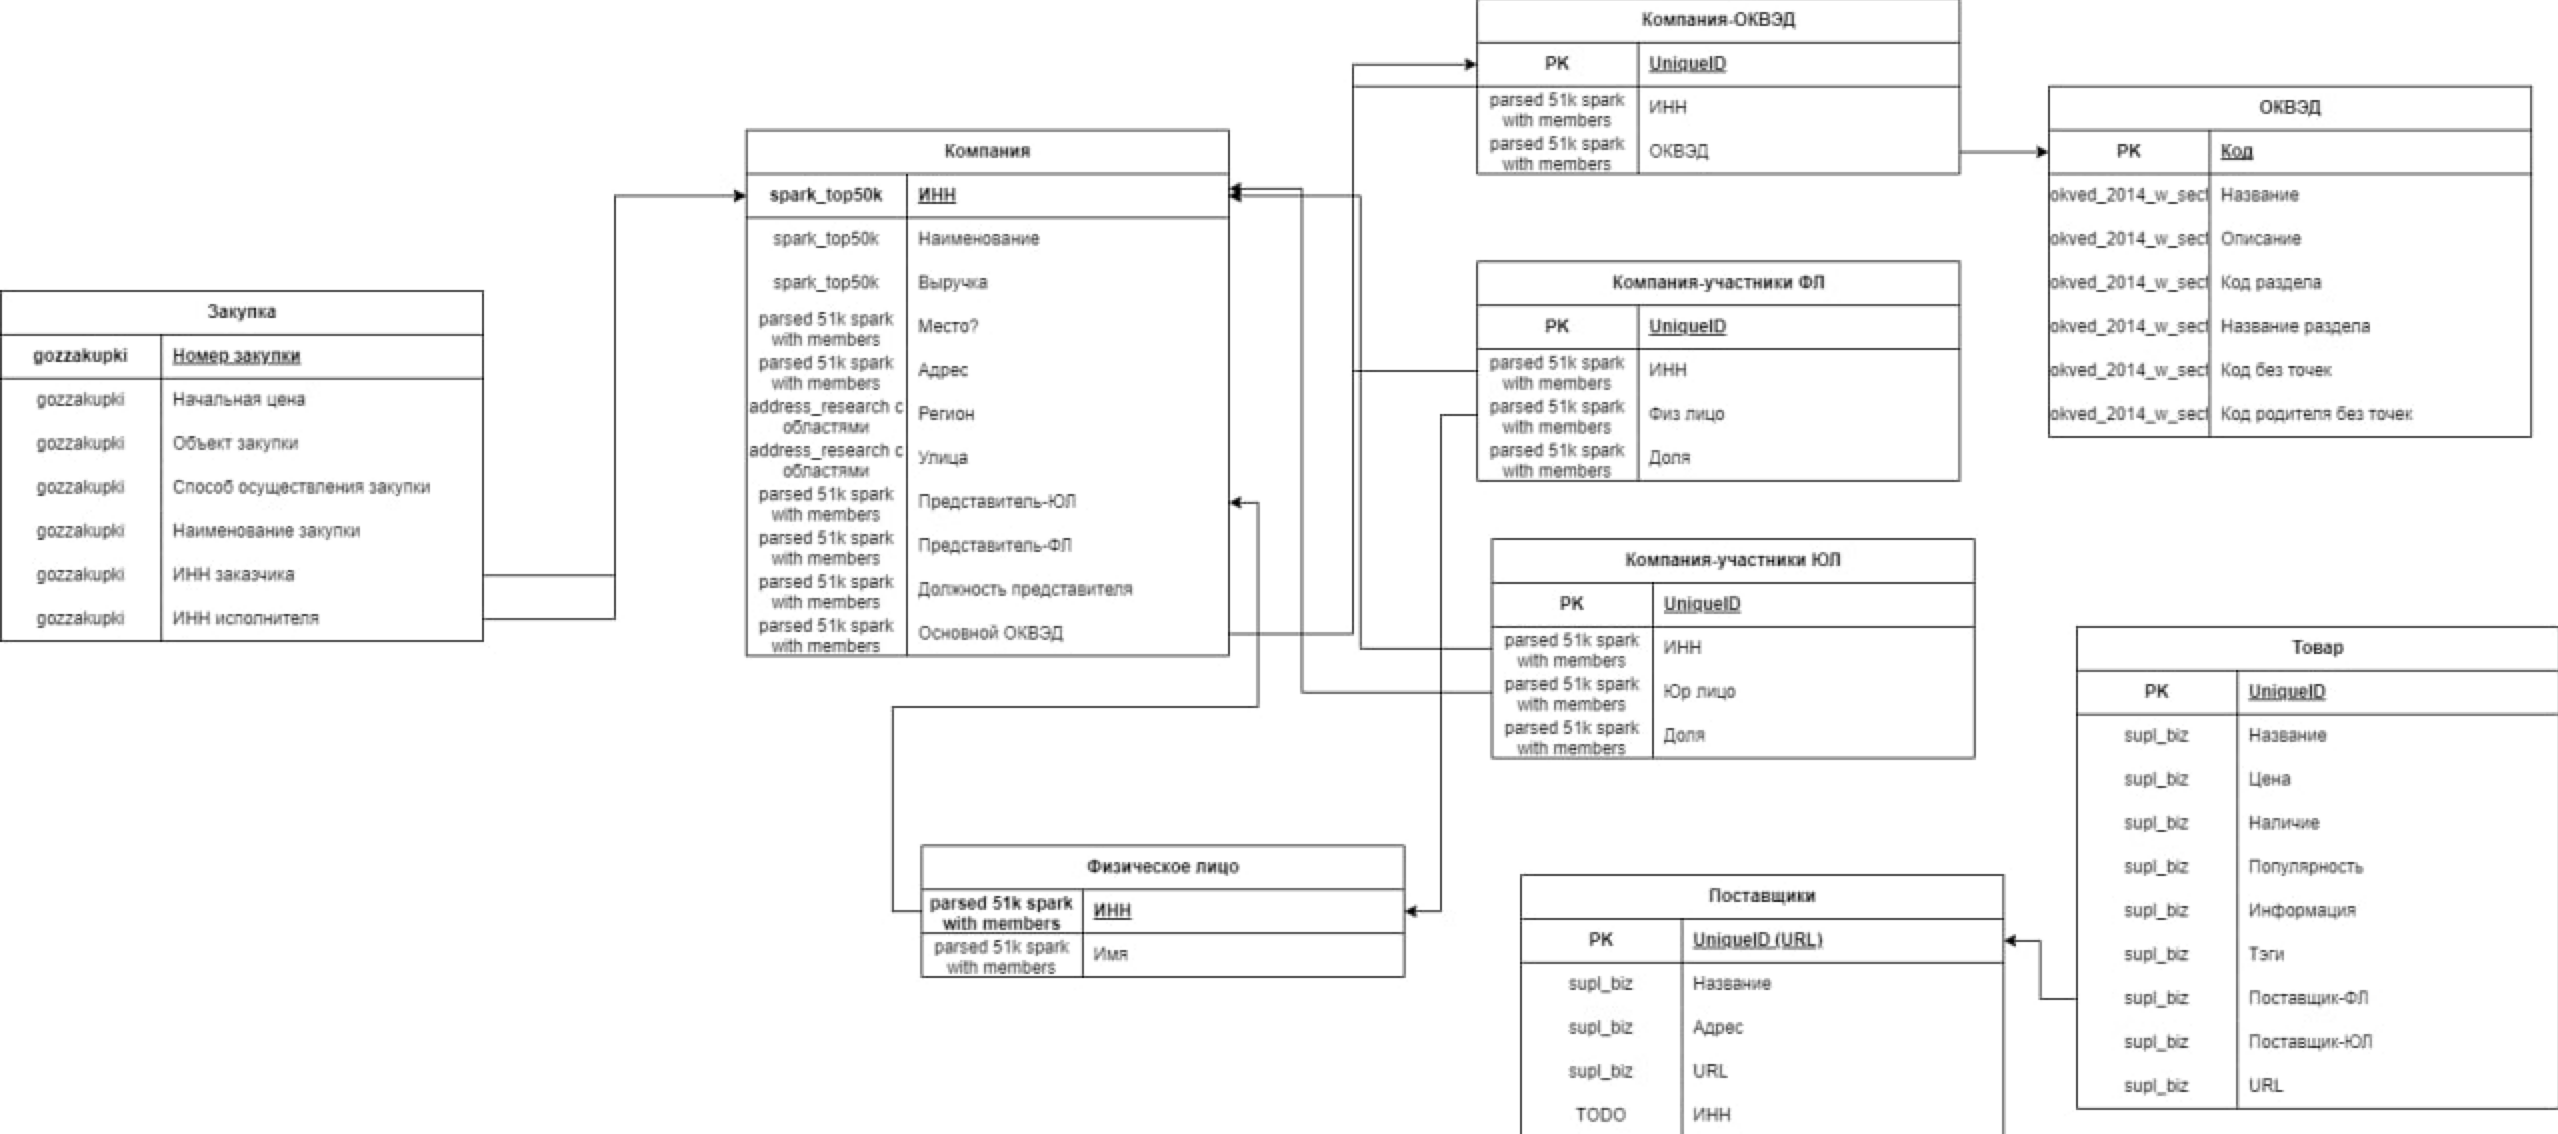

In [5]:
conn = sqlite3.connect('/kaggle/input/recommender-partners/okved_20230329.sqlite3')
cursor = conn.cursor()

In [6]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

In [7]:
tables

[('natural_person',),
 ('supplier',),
 ('okved',),
 ('legal_entity',),
 ('product',),
 ('company_to_okved',),
 ('company_to_natural_member',),
 ('company_to_legal_member',),
 ('procurement',)]

In [8]:
def extract_tables(table):
    cursor.execute(f"SELECT * FROM {table}")

    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[column[0] for column in cursor.description])
    return df

In [9]:
procurements = extract_tables('procurement')
company = extract_tables('legal_entity')
okved = extract_tables('okved')
company_to_okved = extract_tables('company_to_okved')
procurements.head()

,id,start_price,object,method,name,customer_inn,executor_inn
0,32110356755,447993.0,Оказание услуг по организации и проведе...,СБ-АСТ: Закупка у единственного поставщика,Оказание услуг по организации и проведе...,5044000102,7736050003
1,32009458795,1183132.8,Оказание услуг газоснабжения,Закупка у единственного поставщика (подрядчика...,Оказание услуг газоснабжения,7729314745,7736050003
2,32008873158,622893.8,Оказание организационных услуг по празднованию...,СБ-АСТ: Закупка у единственного источника,Оказание организационных услуг по празднованию...,5044000102,7736050003
3,32110655889,54677830.0,Поставка нефтепродуктов,Закупка у единственного поставщика (подрядчика...,Поставка нефтепродуктов,5504037369,5504036333
4,32008994576,321300000.0,Поставка сжиженного углеводородного газа,Закупка у единственного поставщика (подрядчика...,Поставка сжиженного углеводородного газа,5504037369,5504036333


In [10]:
company.head()

,inn,name,revenue,location,address,region,street,post,natural_representative_inn,legal_representative_inn,main_okved_code
0,7706107510,"ПАО ""НК ""РОСНЕФТЬ""",8.000000e+12,ГОРОД МОСКВА,"115035, ГОРОД МОСКВА, НАБ. СОФИЙСКАЯ, Д.26/1",МОСКВА,НАБ СОФИЙСКАЯ,ГЛАВНЫЙ ИСПОЛНИТЕЛЬНЫЙ\nДИРЕКТОР,770370393938,None,06.10.1
1,7736050003,"ПАО ""ГАЗПРОМ""",6.000000e+12,Г.Санкт-Петербург,"197229, Г.Санкт-Петербург, ВН.ТЕР.Г. МУНИЦИПАЛ...",САНКТ-ПЕТЕРБУРГ,ПР-КТ ЛАХТИНСКИЙ,ПРЕДСЕДАТЕЛЬ ПРАВЛЕНИЯ,782506133697,None,46.71
2,5504036333,"ПАО ""ГАЗПРОМ НЕФТЬ""",3.000000e+12,ГОРОД САНКТ-ПЕТЕРБУРГ,"190000, ГОРОД САНКТ-ПЕТЕРБУРГ, УЛ. ПОЧТАМТСКАЯ...",САНКТ-ПЕТЕРБУРГ,УЛ ПОЧТАМТСКАЯ,ГЕНЕРАЛЬНЫЙ ДИРЕКТОР,782570676482,None,46.71
3,7708004767,"ПАО ""ЛУКОЙЛ""",2.000000e+12,ГОРОД МОСКВА,"101000, ГОРОД МОСКВА, Б-Р СРЕТЕНСКИЙ, Д.11",МОСКВА,Б-Р СРЕТЕНСКИЙ,ПРЕЗИДЕНТ,770300105713,None,71.12.3
4,7708503727,"ОАО ""РЖД""",2.000000e+12,Г.Москва,"107174, Г.Москва, ВН.ТЕР.Г. МУНИЦИПАЛЬНЫЙ ОКРУ...",МОСКВА,УЛ НОВАЯ БАСМАННАЯ,ГЕНЕРАЛЬНЫЙ ДИРЕКТОР-\nПРЕДСЕДАТЕЛЬ ПРАВЛЕНИЯ,781306504007,None,49.20


In [11]:
company.region.value_counts().head()

region
МОСКВА                13725
САНКТ-ПЕТЕРБУРГ        4270
МОСКОВСКАЯ ОБЛ         3577
КРАСНОДАРСКИЙ КРАЙ     1627
СВЕРДЛОВСКАЯ ОБЛ       1615
Name: count, dtype: int64

In [12]:
okved.head()

,code,name,info,section_code,section_name,numeric_code,parent_numeric_code
0,01,"Растениеводство и животноводство, охота и пред...",Эта группировка включает:\r\n- два основных ви...,A,"Сельское, лесное хозяйство, охота, рыболовство...",10000,0
1,01.1,Выращивание однолетних культур,Эта группировка включает:\r\n- выращивание одн...,A,"Сельское, лесное хозяйство, охота, рыболовство...",11000,10000
2,01.11,"Выращивание зерновых (кроме риса), зернобобовы...",Эта группировка включает:\r\n- все формы выращ...,A,"Сельское, лесное хозяйство, охота, рыболовство...",11100,11000
3,01.11.1,Выращивание зерновых культур,None,A,"Сельское, лесное хозяйство, охота, рыболовство...",11110,11100
4,01.11.11,Выращивание пшеницы,None,A,"Сельское, лесное хозяйство, охота, рыболовство...",11111,11110


### Построение иерархии ОКВЭД кодов

In [13]:
def build_hierarchy(df):
    hierarchy = defaultdict(list)
    for _, row in df.iterrows():
        parent_code = row['parent_numeric_code']
        current_code = row['numeric_code']
        if parent_code != '0':
            parent_okved = df[df.numeric_code == parent_code].code.values[0]
            num_okved = df[df.numeric_code == current_code].code.values[0]
            hierarchy[parent_okved].append(num_okved)
    return hierarchy

In [14]:
okved_hierarchy = dict(build_hierarchy(okved[okved.code.str.startswith('01')]))

In [15]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [16]:
def visualize_hierarchy_tree(hierarchy):
    g = nx.DiGraph()
    for parent, children in hierarchy.items():
        for child in children:
            g.add_edge(parent, child)
    pos = hierarchy_pos(g, root='01')
    plt.figure(figsize=(12, 8))
    nx.draw(g, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
    plt.title("Hierarchy Visualization with Hierarchical Layout")
    plt.show()

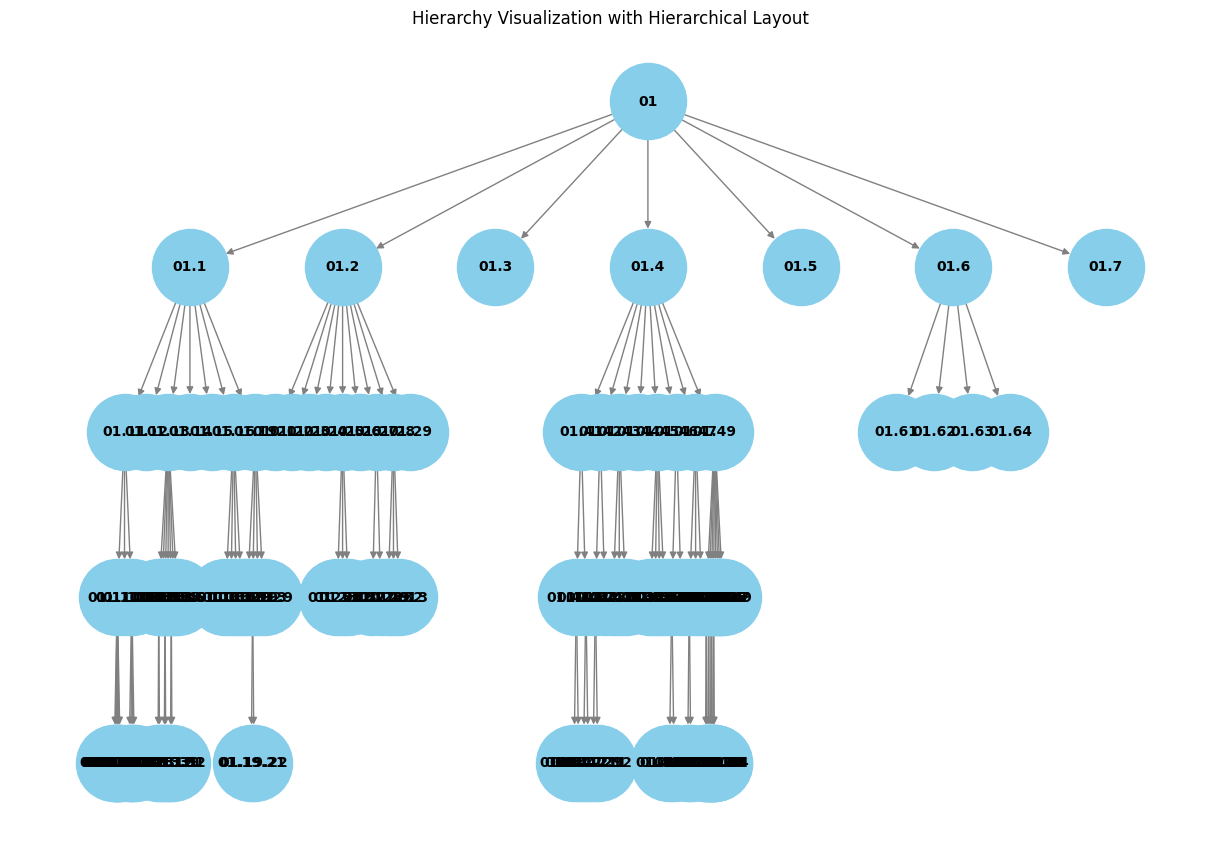

In [17]:
visualize_hierarchy_tree(okved_hierarchy)

In [18]:
okved_hierarchy = dict(build_hierarchy(okved))

### Препроцессинг для дальнейшего упаковывания графа

In [19]:
okved_new = company_to_okved.merge(okved[['code', 'name']], left_on='okved_code', right_on='code', how='left').drop('code', axis=1).dropna()

In [20]:
company_to_okved_grouped = okved_new.groupby('company_inn')[['okved_code', 'name']].agg(list).reset_index()
company_to_okved_grouped.head(1)

,company_inn,okved_code,name
0,1001000742,"[46.46.1, 32.99.9, 38.1, 38.2, 46.38.29, 46.43...","[Торговля оптовая фармацевтической продукцией,..."


In [21]:
merged = company.set_index('inn').join(company_to_okved_grouped.set_index('company_inn')['okved_code'])
merged = merged.join(company_to_okved_grouped.set_index('company_inn')['name'], how='left', rsuffix='_company_name')

In [22]:
merged_without_nan = merged.dropna(subset=['okved_code'])

### Добавление компаний в виде узлов в граф

In [23]:
merged_without_nan = merged.dropna(subset=['revenue', 'region', 'okved_code'])

##### Encoding regions

In [24]:
encoder = OneHotEncoder(sparse=False)
region_encoded = encoder.fit_transform(merged_without_nan[['region']])

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [25]:
region_encoded_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['region']), index=merged_without_nan.index)

_Визуализация связей ОКВЭД: ОКВЭД и КОМПАНИЯ: ОКВЭД_

In [26]:
g = nx.DiGraph()

count = 0
for parent, children in okved_hierarchy.items():
    count += 1
    if count == 2:
        break
    g.add_node(parent, type='okved')
    for child in children:
        g.add_node(child, type='okved')
        g.add_edge(parent, child, type='okved_hierarchy')
        
for index, row in merged_without_nan.iterrows():
    count += 1
    if count == 5:
        break
    node_data = {
        'type': 'company', 
        'revenue': row['revenue'], 
        'region': region_encoded_df.loc[index].to_dict()
    }
    
    g.add_node(index, **node_data)
    
    if row.main_okved_code not in g.nodes():
        g.add_node(row.main_okved_code, type='okved')
        
    g.add_edge(index, row.main_okved_code, type='company_okved', weight=2)
    for i in range(1, len(row.okved_code)):
        if row.okved_code[i] not in g.nodes():
            g.add_node(row.okved_code[i], type='okved')
        g.add_edge(index, row.okved_code[i], type='company_okved', weight=1)

In [27]:
def visualize_graph(g):
    pos = nx.random_layout(g)
    
    plt.figure(figsize=(15, 10))

    company_nodes = [n for n, attr in g.nodes(data=True) if attr['type'] == 'company']
    nx.draw_networkx_nodes(g, pos, nodelist=company_nodes, node_color='blue', node_size=500, label='Company')

    okved_nodes = [n for n, attr in g.nodes(data=True) if attr['type'] == 'okved']
    nx.draw_networkx_nodes(g, pos, nodelist=okved_nodes, node_color='green', node_size=500, label='OKVED')
    nx.draw_networkx_edges(g, pos, edgelist=g.edges(), arrows=True)

    labels = {n: n if attr['type'] == 'company' else f'OKVED {n}' for n, attr in g.nodes(data=True)}
    nx.draw_networkx_labels(g, pos, labels=labels)
    
    plt.legend(scatterpoints=1)
    plt.show()

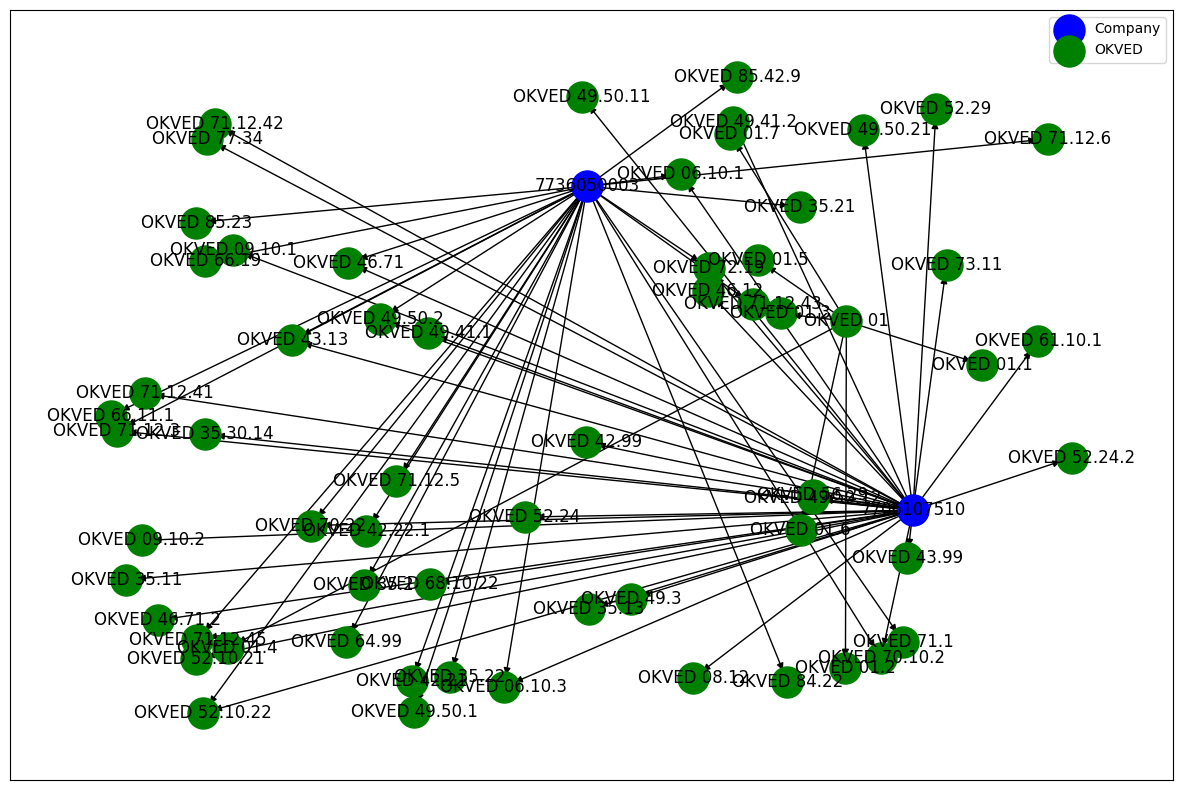

In [28]:
visualize_graph(g)

### Добавление таблицы с закупками

_Фильтрация компаний в customer_inn и executor_inn по наличию в таблице company_

In [29]:
count = 0
train_lst, train_lst_executor = [], []
for index, row in procurements.iterrows():
    if merged_without_nan[merged_without_nan.index == row.customer_inn].shape[0] > 0:
        if row.customer_inn not in train_lst:
            train_lst.append(row.customer_inn)
        count += 1
    if merged_without_nan[merged_without_nan.index == row.executor_inn].shape[0] > 0:
        if row.executor_inn not in train_lst_executor:
            train_lst_executor.append(row.executor_inn)
        count += 1

In [30]:
count, procurements.shape

(33599, (24807, 7))

In [31]:
combined_list = list(set(train_lst + train_lst_executor))

In [32]:
len(combined_list), len(train_lst), len(train_lst_executor)

(3454, 563, 3124)

In [33]:
procurements = procurements.query(
    'customer_inn in @train_lst & executor_inn in @train_lst_executor'
)

In [34]:
merged_without_nan = merged_without_nan.query('index in @combined_list')

##### Представление объектов закупки в эмбеддинги

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [36]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased').to(device)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [37]:
def encode_text(text):
    inputs = tokenizer(
        text, 
        return_tensors='pt', 
        truncation=True, 
        padding=True, 
        max_length=128
    ).to(device)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().detach().numpy().flatten()

In [38]:
procurements['object'].iloc[:5].values

array(['Поставка нефтепродуктов',
       'Поставка сжиженного углеводородного газа',
       'Выполнение периодических регламентных работ (ПРР), метрологической поверки, ремонта (при необходимости) устройств безопасности, установленного на железнодорожном подвижном составе , находящемся или в собственности или аренде, или на обслуживании у Заказчика',
       'Оказание услуг по  холодному водоснабжению и водоотведению',
       'Отпуск и потребление тепловой энергии в горячей воде'],
      dtype=object)

In [39]:
def extract_key_phrases(text):
    rake = Rake()
    rake.extract_keywords_from_text(text)
    key_phrases = rake.get_ranked_phrases()

    key_phrases = key_phrases[:1]
    key_phrases_str = ', '.join(key_phrases)
    final_phrases = re.sub(r'[^\w\s]|[\d]', '', key_phrases_str)
    final_phrases = re.sub(r'по адресу:?', '', final_phrases)
    return final_phrases

In [40]:
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 58.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 85.5 MB/s eta 0:00:00:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [41]:
nlp = spacy.load('ru_core_news_sm')
procurements['new_object'] = procurements.object.apply(extract_key_phrases)

In [42]:
procurements.new_object.iloc[:5]

3                              поставка нефтепродуктов
4             поставка сжиженного углеводородного газа
5           находящемся или в собственности или аренде
7    оказание услуг по холодному водоснабжению и во...
8    отпуск и потребление тепловой энергии в горяче...
Name: new_object, dtype: object

In [43]:
procurements['object_emb'] = procurements['new_object'].apply(encode_text)

In [44]:
vectors = procurements['object_emb'].tolist()[12:17]
objects = procurements['object'].tolist()[12:17]

vectors_df = pd.DataFrame(vectors)
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_model.fit_transform(vectors_df)

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/conda/lib/python3.10/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


/tmp/ipykernel_34/540239182.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=50, cmap='Spectral')


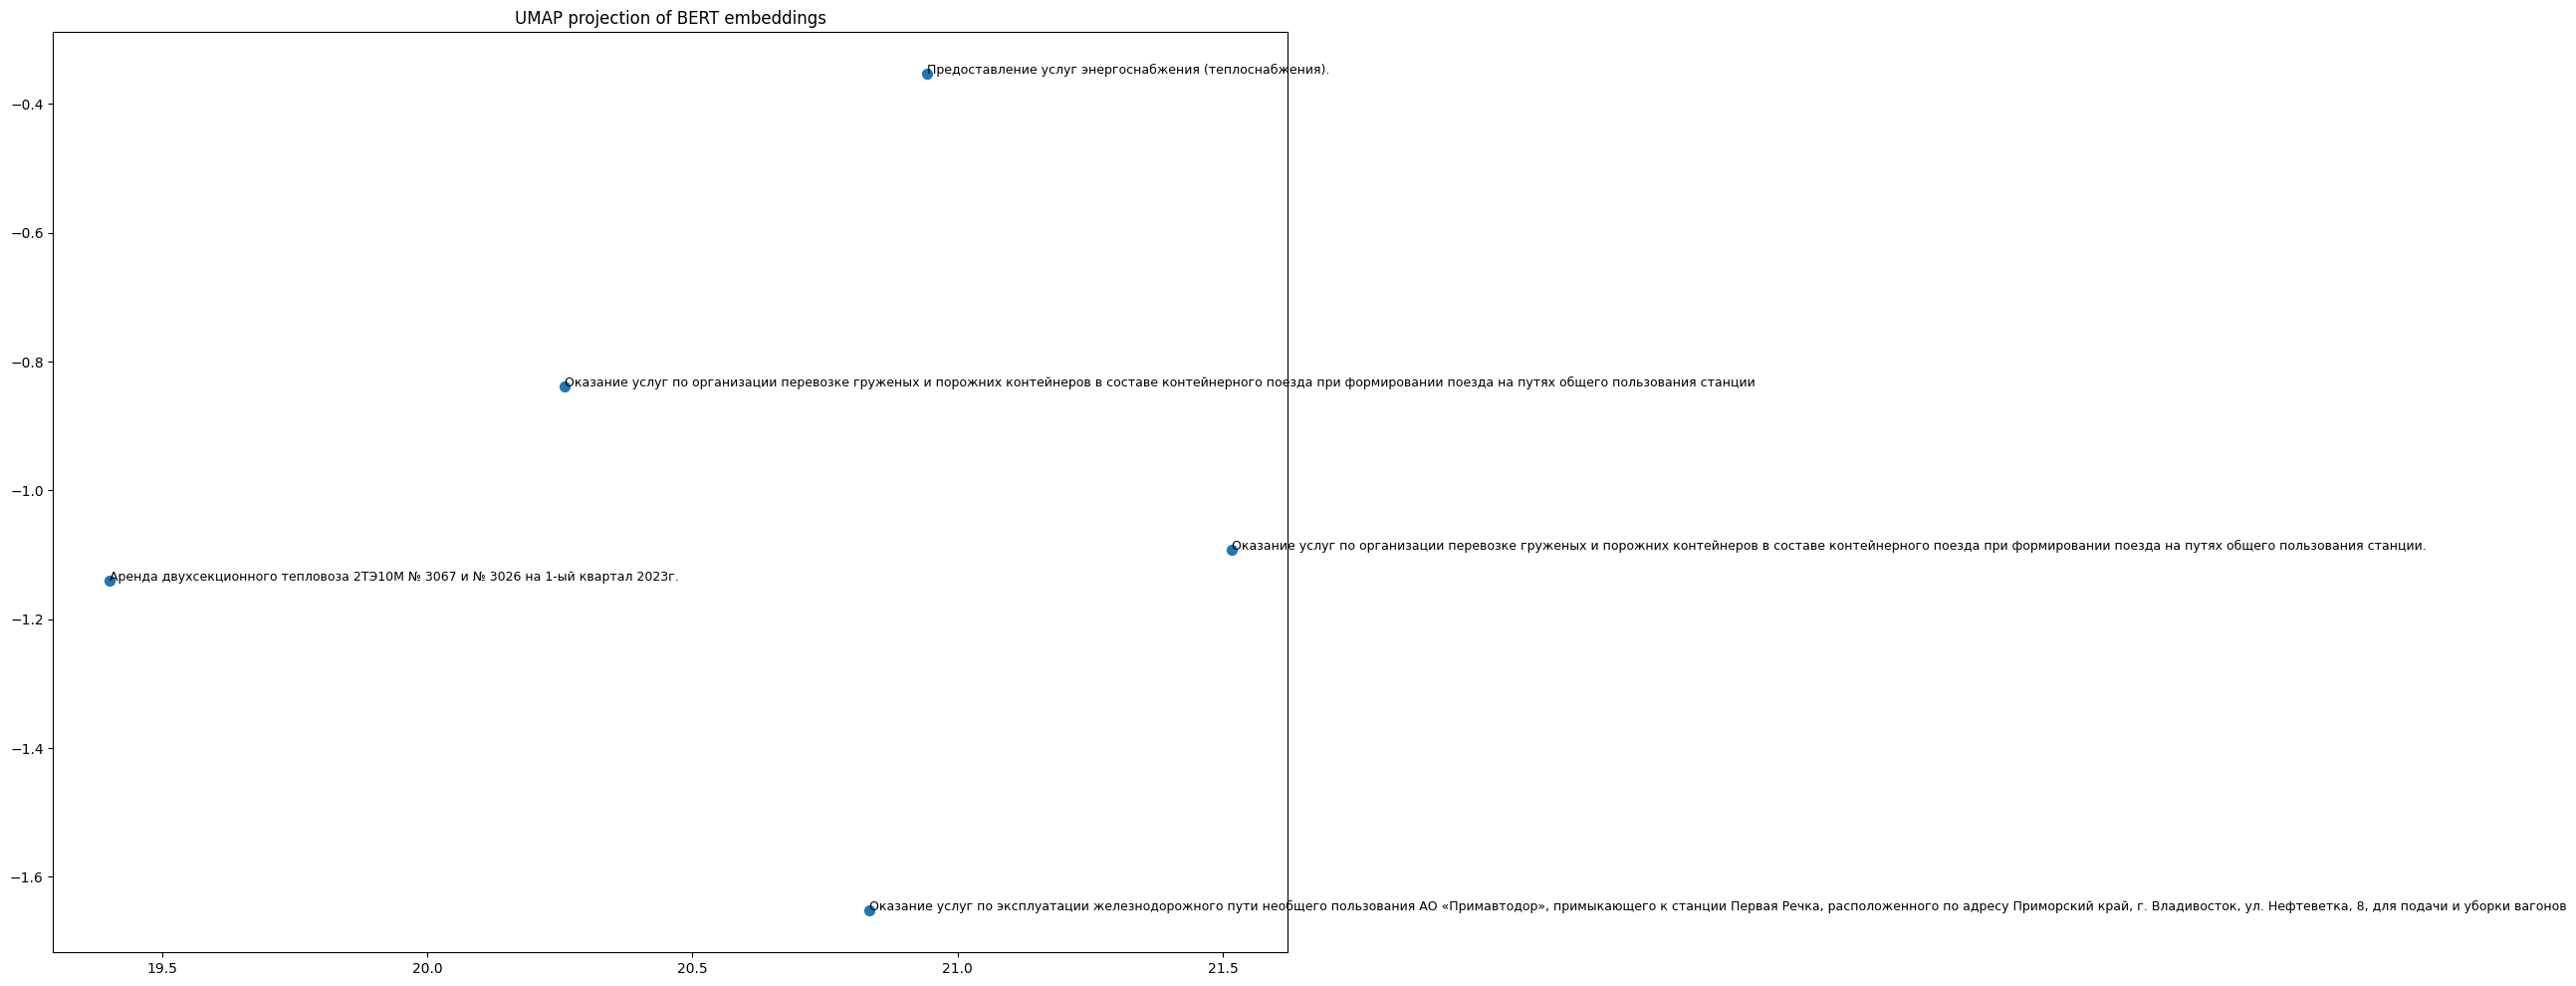

In [45]:
plt.figure(figsize=(16, 12))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=50, cmap='Spectral')

for i, obj in enumerate(objects):
    plt.text(umap_embeddings[i, 0], umap_embeddings[i, 1], obj, fontsize=9)

plt.title('UMAP projection of BERT embeddings')
plt.show()

In [46]:
procurements = procurements.drop_duplicates(subset=['customer_inn', 'executor_inn'])

### Построение итогового графа 

In [47]:
def convert_nx_to_dgl():
    data_dict = {
        ('okved', 'okved_hierarchy', 'okved'): ([], []),
        ('company', 'company_okved', 'okved'): ([], []),
        ('company', 'deal', 'company'): ([], [])
    }
    
    node_features = {
        'okved': {'id': []},
        'company': {'revenue': [], 'region': [], 'id': []} # , 'region': []
    }
    
    edge_features = {
        ('company', 'deal', 'company'): {'start_price': [], 'object_vector': []} # , 'object_vector': []
    }
    
    node_mapping = {'okved': {}, 'company': {}}
    node_counter = {'okved': 0, 'company': 0}
    
    # Добавление ОКВЭД узлов и связей
    for parent, children in okved_hierarchy.items():
        if parent not in node_mapping['okved']:
            node_mapping['okved'][parent] = node_counter['okved']
            node_features['okved']['id'].append(parent)
            node_counter['okved'] += 1
        parent_idx = node_mapping['okved'][parent]
        
        for child in children:
            if child not in node_mapping['okved']:
                node_mapping['okved'][child] = node_counter['okved']
                node_features['okved']['id'].append(child) 
                node_counter['okved'] += 1
            child_idx = node_mapping['okved'][child]
            
            data_dict[('okved', 'okved_hierarchy', 'okved')][0].append(parent_idx)
            data_dict[('okved', 'okved_hierarchy', 'okved')][1].append(child_idx)
    
    # Добавление компаний в виде узлов и связей с ОКВЭДами
    for index, row in merged_without_nan.iterrows():
        if index not in node_mapping['company']:
            node_mapping['company'][index] = node_counter['company']
            node_features['company']['revenue'].append(float(row['revenue']))
            node_features['company']['region'].append(region_encoded_df.loc[index].values.astype(float))
            node_features['company']['id'].append(int(index))  
            node_counter['company'] += 1
        company_idx = node_mapping['company'][index]
        
        if row.main_okved_code not in node_mapping['okved']:
            node_mapping['okved'][row.main_okved_code] = node_counter['okved']
            node_features['okved']['id'].append(row.main_okved_code) 
            node_counter['okved'] += 1
        main_okved_idx = node_mapping['okved'][row.main_okved_code]
        
        data_dict[('company', 'company_okved', 'okved')][0].append(company_idx)
        data_dict[('company', 'company_okved', 'okved')][1].append(main_okved_idx)
        
        for okved in row.okved_code:
            if okved not in node_mapping['okved']:
                node_mapping['okved'][okved] = node_counter['okved']
                node_features['okved']['id'].append(okved) 
                node_counter['okved'] += 1
            okved_idx = node_mapping['okved'][okved]
            
            data_dict[('company', 'company_okved', 'okved')][0].append(company_idx)
            data_dict[('company', 'company_okved', 'okved')][1].append(okved_idx)

    # Добавление связей между компаниями
    for _, row in procurements.iterrows():
        customer_idx = node_mapping['company'][row['customer_inn']]
        executor_idx = node_mapping['company'][row['executor_inn']]
        
        if (customer_idx, executor_idx) not in zip(data_dict[('company', 'deal', 'company')]):
            data_dict[('company', 'deal', 'company')][0].append(customer_idx)
            data_dict[('company', 'deal', 'company')][1].append(executor_idx)

            edge_features[('company', 'deal', 'company')]['start_price'].append(float(row['start_price']))
            edge_features[('company', 'deal', 'company')]['object_vector'].append(row['object_emb'].astype(float))
    
    dgl_graph = dgl.heterograph(data_dict)
    
    # Добавление признаков узлов
    dgl_graph.nodes['okved'].data['id'] = torch.tensor([int(x.replace('.', '')) for x in node_features['okved']['id']], dtype=torch.long)
    dgl_graph.nodes['company'].data['revenue'] = torch.tensor(node_features['company']['revenue'], dtype=torch.float32)
    dgl_graph.nodes['company'].data['region'] = torch.tensor(np.stack(node_features['company']['region']), dtype=torch.float32)
    dgl_graph.nodes['company'].data['id'] = torch.tensor(node_features['company']['id'], dtype=torch.long)
    
    # Добавление признаков рёбер
    dgl_graph.edges['deal'].data['start_price'] = torch.tensor(edge_features[('company', 'deal', 'company')]['start_price'], dtype=torch.float32)
    dgl_graph.edges['deal'].data['object_vector'] = torch.tensor(np.stack(edge_features[('company', 'deal', 'company')]['object_vector']), dtype=torch.float32)
    
    return dgl_graph, node_mapping


In [48]:
dgl_graph, node_mapping = convert_nx_to_dgl()

In [49]:
dgl_graph

Graph(num_nodes={'company': 3454, 'okved': 2707},
      num_edges={('company', 'company_okved', 'okved'): 73135, ('company', 'deal', 'company'): 3572, ('okved', 'okved_hierarchy', 'okved'): 2547},
      metagraph=[('company', 'okved', 'company_okved'), ('company', 'company', 'deal'), ('okved', 'okved', 'okved_hierarchy')])

In [50]:
dgl_graph.nodes['okved'].data, dgl_graph.nodes['company'].data

({'id': tensor([   1,   11,   12,  ...,  990, 8690, 6420])},
 {'revenue': tensor([6.0000e+12, 3.0000e+12, 2.0000e+12,  ..., 4.8400e+08, 4.8400e+08,
         4.8300e+08]), 'region': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), 'id': tensor([7736050003, 5504036333, 7708503727,  ..., 4223030694, 5715004620,
         5256122751])})

In [51]:
dgl_graph.edges['deal'].data

{'start_price': tensor([54677832.0000,   720501.6875,   787695.7500,  ...,
         2300000.0000, 28175398.0000,  1668000.0000]), 'object_vector': tensor([[-0.3077, -0.8293,  0.5812,  ...,  0.7296,  0.3729,  0.3300],
        [-0.3139, -0.0539,  0.9810,  ...,  0.5944, -0.4324, -0.3288],
        [-0.2255, -0.7015,  0.7027,  ..., -0.0410, -0.0933, -0.6801],
        ...,
        [ 0.2555, -0.3162,  0.6442,  ...,  0.4432,  0.0690, -0.0445],
        [-0.1545, -0.5040,  0.6463,  ...,  0.4252,  0.2429, -0.4258],
        [-0.1258, -0.1916,  1.1130,  ...,  0.2415,  0.5614, -0.1374]])}

### Link prediction

In [52]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [53]:
revenue = dgl_graph.nodes['company'].data['revenue']
revenue = (revenue - revenue.mean()) / revenue.std()
company_features = torch.cat([revenue.reshape(-1, 1), 
                              dgl_graph.nodes['company'].data['region']], dim=1)
dgl_graph.nodes['company'].data['feat'] = company_features

in_feats = company_features.shape[1]
okved_features = torch.zeros((dgl_graph.number_of_nodes('okved'), in_feats))
dgl_graph.nodes['okved'].data['feat'] = okved_features

In [54]:
class HeteroGraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, num_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroGraphConv({
                'okved_hierarchy': SAGEConv(in_feats, hidden_feats, 'mean'),
                'company_okved': SAGEConv(in_feats, hidden_feats, 'mean'),
                'deal': SAGEConv(in_feats, hidden_feats, 'mean')
            }, aggregate='sum')
            self.layers.append(conv)
            in_feats = hidden_feats
        self.linear = nn.Linear(hidden_feats, out_feats)

    def forward(self, g, inputs):
        h = inputs
        for layer in self.layers:
            h = layer(g, h)
            h = {k: F.relu(v) for k, v in h.items()}
        h = {k: self.linear(v) for k, v in h.items()}
        return h

class HeteroDotProductPredictor(nn.Module):
    def forward(self, graph, h, etype):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'), etype=etype)
            return graph.edges[etype].data['score']

class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.sage = HeteroGraphSAGE(in_features, hidden_features, out_features, 2)
        self.pred = HeteroDotProductPredictor()
    def forward(self, g, x, etype):
        h = self.sage(g, x)
        return h

def construct_negative_graph(graph, etype, num_samples):
    utype, _, vtype = etype
    neg_src = []
    neg_dst = []
    while len(neg_src) < num_samples:
        u = torch.randint(0, graph.num_nodes(utype), (num_samples,))
        v = torch.randint(0, graph.num_nodes(vtype), (num_samples,))
        mask = ~graph.has_edges_between(u, v, etype=etype)
        u = u[mask]
        v = v[mask]
        neg_src.extend(u.tolist())
        neg_dst.extend(v.tolist())
        if len(neg_src) > num_samples:
            neg_src = neg_src[:num_samples]
            neg_dst = neg_dst[:num_samples]
    return torch.tensor(neg_src), torch.tensor(neg_dst)

def split_data(graph, etype, train_ratio=0.8):
    u, v = graph.edges(etype=etype)
    num_edges = len(u)
    num_train = int(train_ratio * num_edges)
    
    indices = list(range(num_edges))
    random.shuffle(indices)
    
    train_indices = indices[:num_train]
    test_indices = indices[num_train:]
    
    train_u, train_v = u[train_indices], v[train_indices]
    test_u, test_v = u[test_indices], v[test_indices]
    
    return (train_u, train_v), (test_u, test_v)

# def compute_loss(pos_score, neg_score):
#     n_edges = pos_score.shape[0]
#     return (1 - pos_score + neg_score.view(n_edges, -1)).clamp(min=0).mean()

def predict(model, graph, node_features, edge_type, pos_samples, neg_samples=None):
    model.eval()
    with torch.no_grad():
        h = model(graph, node_features, edge_type)
        
        pos_src, pos_dst = pos_samples
        pos_graph = dgl.heterograph(
            {edge_type: (pos_src, pos_dst)},
            num_nodes_dict={ntype: graph.num_nodes(ntype) for ntype in graph.ntypes})
        h_pos = model(pos_graph, node_features, edge_type)
        pos_score = model.pred(pos_graph, h_pos, edge_type).numpy()
        pos_prob = torch.sigmoid(torch.tensor(pos_score)).numpy()
        
        if neg_samples is not None:
            neg_src, neg_dst = neg_samples
            neg_graph = dgl.heterograph(
                {edge_type: (neg_src, neg_dst)},
                num_nodes_dict={ntype: graph.num_nodes(ntype) for ntype in graph.ntypes})
            h_neg = model(neg_graph, node_features, edge_type)
            neg_score = model.pred(neg_graph, h_neg, edge_type).numpy()
            neg_prob = torch.sigmoid(torch.tensor(neg_score)).numpy()
            return pos_prob, neg_prob
        
        return pos_prob

def train(graph, model, optimizer, train_pos_edges, train_neg_edges):
    model.train()
    optimizer.zero_grad()
    
    h = {
        'company': graph.nodes['company'].data['feat'],
        'okved': graph.nodes['okved'].data['feat']
    }
    out = model(graph, h, ('company', 'deal', 'company'))['company']
    
    pos_score = (out[train_pos_edges[:, 0]] * out[train_pos_edges[:, 1]]).sum(dim=1)
    neg_score = (out[train_neg_edges[:, 0]] * out[train_neg_edges[:, 1]]).sum(dim=1)
    
    pos_loss = F.binary_cross_entropy_with_logits(pos_score, torch.ones(len(train_pos_edges)))
    neg_loss = F.binary_cross_entropy_with_logits(neg_score, torch.zeros(len(train_neg_edges)))
    
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [55]:
(train_u, train_v), (test_u, test_v) = split_data(dgl_graph, 'deal')

In [56]:
company_okved_src, company_okved_dst = dgl_graph.edges(etype=('company', 'company_okved', 'okved'))
okved_hierarchy_src, okved_hierarchy_dst = dgl_graph.edges(etype=('okved', 'okved_hierarchy', 'okved'))

num_nodes_dict = {
    'company': dgl_graph.num_nodes('company'),
    'okved': dgl_graph.num_nodes('okved')
}

train_graph = dgl.heterograph({
    ('company', 'deal', 'company'): (train_u, train_v),
    ('company', 'company_okved', 'okved'): (company_okved_src, company_okved_dst),
    ('okved', 'okved_hierarchy', 'okved'): (okved_hierarchy_src, okved_hierarchy_dst)
}, num_nodes_dict=num_nodes_dict)

test_graph = dgl.heterograph({
    ('company', 'deal', 'company'): (test_u, test_v),
    ('company', 'company_okved', 'okved'): (company_okved_src, company_okved_dst),
    ('okved', 'okved_hierarchy', 'okved'): (okved_hierarchy_src, okved_hierarchy_dst)
}, num_nodes_dict=num_nodes_dict)

In [57]:
train_graph.nodes['company'].data['feat'] = dgl_graph.nodes['company'].data['feat']
train_graph.nodes['okved'].data['feat'] = dgl_graph.nodes['okved'].data['feat']

train_deal_mask = dgl_graph.edge_ids(train_u, train_v, etype=('company', 'deal', 'company'))
train_graph.edges['deal'].data['start_price'] = dgl_graph.edges['deal'].data['start_price'][train_deal_mask]
train_graph.edges['deal'].data['object_vector'] = dgl_graph.edges['deal'].data['object_vector'][train_deal_mask]

test_graph.nodes['company'].data['feat'] = dgl_graph.nodes['company'].data['feat']
test_graph.nodes['okved'].data['feat'] = dgl_graph.nodes['okved'].data['feat']

test_deal_mask = dgl_graph.edge_ids(test_u, test_v, etype=('company', 'deal', 'company'))
test_graph.edges['deal'].data['start_price'] = dgl_graph.edges['deal'].data['start_price'][test_deal_mask]
test_graph.edges['deal'].data['object_vector'] = dgl_graph.edges['deal'].data['object_vector'][test_deal_mask]

In [65]:
node_features = {
    'company': dgl_graph.nodes['company'].data['feat'],
    'okved': dgl_graph.nodes['okved'].data['feat']
}

In [61]:
train_neg_edges = construct_negative_graph(train_graph, ('company', 'deal', 'company'), len(train_u))
test_neg_edges = construct_negative_graph(test_graph, ('company', 'deal', 'company'), len(test_u))

train_neg_edges = torch.stack((train_neg_edges[0], train_neg_edges[1]), dim=1)
test_neg_edges = torch.stack((test_neg_edges[0], test_neg_edges[1]), dim=1)

train_pos_edges = torch.tensor(list(zip(train_u, train_v)), dtype=torch.long)

In [62]:
len(test_u) + len(train_u)

3572

In [88]:
hidden_feats = 64
out_feats = 64
num_layers = 5

model = Model(in_feats, hidden_feats, out_feats, dgl_graph.etypes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

for epoch in tqdm(range(20)):
    loss = train(train_graph, model, optimizer, train_pos_edges, train_neg_edges)
    if epoch % 5 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Loss: 1.4289919137954712
Epoch 5, Loss: 1.3130875825881958
Epoch 10, Loss: 1.2416062355041504
Epoch 15, Loss: 1.171870231628418


In [89]:
pos_probabilities, neg_probabilities = predict(model, test_graph, node_features, ('company', 'deal', 'company'), (test_u, test_v), (test_neg_edges[:, 0], test_neg_edges[:, 1]))

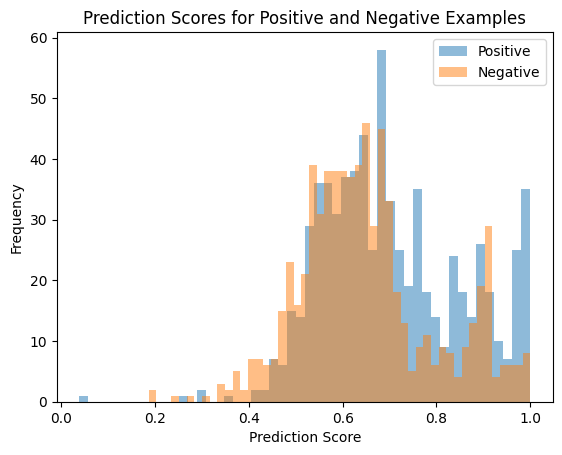

In [90]:
plt.hist(pos_probabilities, bins=50, alpha=0.5, label='Positive')
plt.hist(neg_probabilities, bins=50, alpha=0.5, label='Negative')
plt.legend(loc='upper right')
plt.xlabel('Prediction Score')
plt.ylabel('Frequency')
plt.title('Prediction Scores for Positive and Negative Examples')
plt.show()

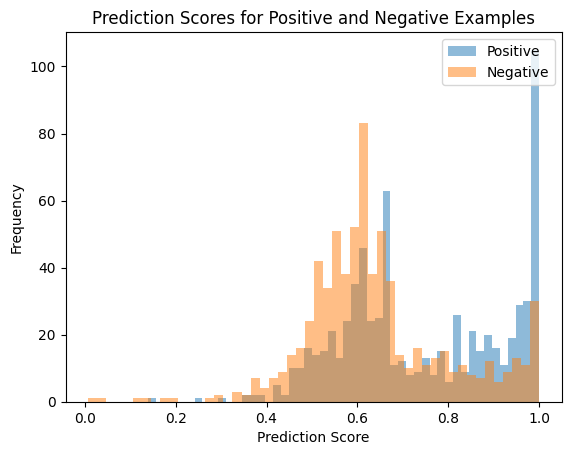

In [361]:
plt.hist(pos_probabilities, bins=50, alpha=0.5, label='Positive')
plt.hist(neg_probabilities, bins=50, alpha=0.5, label='Negative')
plt.legend(loc='upper right')
plt.xlabel('Prediction Score')
plt.ylabel('Frequency')
plt.title('Prediction Scores for Positive and Negative Examples')
plt.show()

In [91]:
pos_df = pd.DataFrame({
    'customer': test_u.numpy(),
    'executor': test_v.numpy(),
    'probability': pos_probabilities.squeeze(1)
})

neg_df = pd.DataFrame({
    'customer': test_neg_edges[:, 0].numpy(),
    'executor': test_neg_edges[:, 1].numpy(),
    'probability': neg_probabilities.squeeze(1)
})

In [92]:
pos_df.sort_values(by='probability', ascending=False)

,customer,executor,probability
299,3177,2510,0.999999
296,574,2159,0.999995
345,959,2043,0.999993
366,574,100,0.999986
504,959,1509,0.999889
...,...,...,...
594,1290,693,0.356968
277,365,2975,0.296784
353,3355,11,0.294230
358,1737,27,0.264051


In [93]:
for key, value in node_mapping['company'].items():
    if value == 3177:
        example_customer = key
    if value == 2510:
        example_executor = key

In [98]:
procurements.query('executor_inn == @example_executor & customer_inn == @example_customer').new_object.values

array(['заключение дополнительного соглашения к договору поставки автомобиля камаз '],
      dtype=object)

In [95]:
merged_without_nan[merged_without_nan.index == example_customer]

,name,revenue,location,address,region,street,post,natural_representative_inn,legal_representative_inn,main_okved_code,okved_code,name_company_name
inn,,,,,,,,,,,,
3807000276,"МУП ""ВОДОКАНАЛ"" Г.ИРКУТСКА",2.000000e+09,"ИРКУТСКАЯ ОБЛАСТЬ,\nГ. ИРКУТСК","664081, ИРКУТСКАЯ ОБЛАСТЬ, Г. ИРКУТСК, УЛ. СТА...",ИРКУТСКАЯ ОБЛ,УЛ СТАНИСЛАВСКОГО,ДИРЕКТОР,381400144625,None,36.00.2,"[36.00.2, 33.12, 35.30.14, 35.30.2, 35.30.3, 4...",[Распределение воды для питьевых и промышленны...


In [96]:
merged_without_nan[merged_without_nan.index == example_executor]

,name,revenue,location,address,region,street,post,natural_representative_inn,legal_representative_inn,main_okved_code,okved_code,name_company_name
inn,,,,,,,,,,,,
3812127630,"ООО ""БАЙКАЛ-АВТОТРАК-СЕРВИС""",3.000000e+09,"ИРКУТСКАЯ ОБЛАСТЬ,\nГ. ИРКУТСК","664043, ИРКУТСКАЯ ОБЛАСТЬ, Г. ИРКУТСК, УЛ. РАК...",ИРКУТСКАЯ ОБЛ,УЛ РАКИТНАЯ,ГЕНЕРАЛЬНЫЙ ДИРЕКТОР,384903428227,None,45.31.1,"[45.31.1, 33.12, 45.1, 45.11.1, 45.11.4, 45.19...","[Торговля оптовая автомобильными деталями, узл..."


In [383]:
all_probabilities = np.concatenate([pos_probabilities, neg_probabilities])
labels = np.concatenate([np.ones(len(pos_probabilities)), np.zeros(len(neg_probabilities))])

roc_auc = roc_auc_score(labels, all_probabilities)
print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.6711


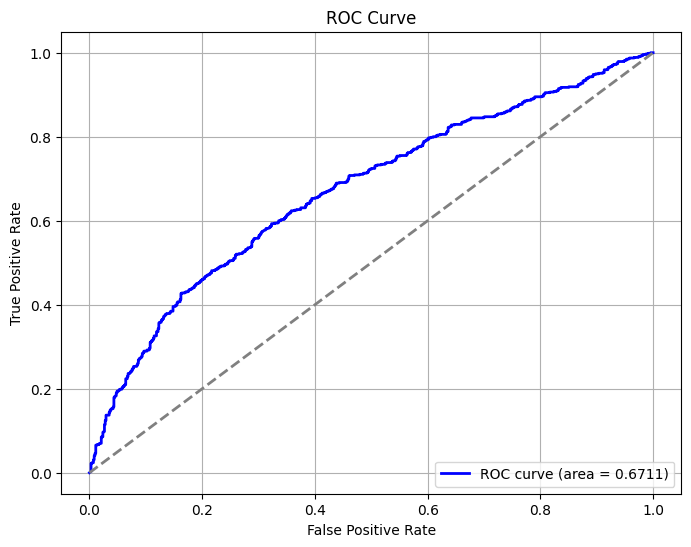

In [384]:
fpr, tpr, _ = roc_curve(labels, all_probabilities)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()